# Section 4: Use a Catalog to Visualize Objects in the Map

This notebook will demonstrate how to use a catalog to visualize objects in the maps as well as how to stack on the locations of the pointsources in that catalog.

Notebook Info | Value
---|---
Dependencies | `numpy`, `scipy`, `healpy`, `matplotlib`, `pixell`, `astropy`
Data products | "act_planck_dr4.01_s08s16_AA_f150_night_map_dg_I.fits"
 | "act_planck_dr4.01_s08s16_AA_f150_night_map_d56_I.fits"
 | "E-D56Clusters.fits"
 | "messier_objs.csv"
Optional Data Products | "act_planck_dr4.01_s08s16_AA_f150_night_map.fits"
Memory usage | Minimal unless using the optional full resolution and area map
Contributors | Kyra Fichman, Maya Mallaby-Kay, Zach Atkins

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to ACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-16 Coadded maps from [Naess et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_N20.pdf) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al (2019)](https://arxiv.org/abs/1911.05717)

> [Section 7](Section_7_power_spectra_part_1.ipynb): Power Spectra Part 1 - Harmonic Analysis using CAR maps [Naess et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_N20.pdf)

> [Section 8](Section_8_power_spectra_part_2.ipynb) Power Spectra Part 2 - Power Spectrum example using Nawrapper [Aiola et al](https://phy-act1.princeton.edu/public/saiola/act_dr4_A20.pdf) and [Choi et al](https://phy-act1.princeton.edu/public/saiola/act_dr4_C20.pdf) 

> [Section 9](Section_9_Noise_sims.ipynb): Generating Noise Simulations 

> [Section 10](Section_10_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 

> [Section 11](Section_11_ACT_likelihood.ipynb): Using the ACT Likelihood code

> [Section 12](Section_12_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. 2020](https://arxiv.org/pdf/2007.14405.pdf)
 
---

## Initialize notebook

Again, we rerun the first notebook in order to import packages and set the data path.  From there we will read in the coadded map.  Users can choose to import the lower resolution, full-size map along with the full-resolution cutout, or the full resolution, full-size map depending on their computer's capabilities.  To that end make the appropriate choice for your computer and edit the code if need be.

In [1]:
%run Section_1_Introduction.ipynb

from scipy.interpolate import interp1d
from matplotlib import cm
from astropy.io import ascii, fits
import astropy.coordinates as coord
import astropy.units as u
import random 

# Redefine our plotting function from section 2
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

As in notebook 2, due to the large size of the coadded map, we give you two options when working with these maps:

>1) You can read in the full sky-area, downgraded intensity map, along with a full resolution cutout of the sky.  Between the two maps you'll be able to see the scope of our data as well as the depth.

>2) Alternatively, if you have space and resources for the full file, but don't want to read in the whole map, we demonstrate how to read in just a small area of the full, higher-resolution map.

Here we default to the first option but feel free to change to the second by switching which cell is commented out.

In [2]:
#Comment this block and run the next one if you are using the full maps

#Option 1: Read in the downgraded map and the full-res cutout

imap_dg = enmap.read_map(path + "act_planck_dr4.01_s08s16_AA_f150_night_map_dg_I.fits")

imap_d56 = enmap.read_map(path + "act_planck_dr4.01_s08s16_AA_f150_night_map_d56_I.fits")

This second box is commented out currently but if you have the full maps downloaded then feel free to read that in instead of the maps in the cell above.

One thing worth looking at here is that the `[0]` in `imap = enmap.read_map(path + "act_planck_dr4.01_s08s16_AA_f150_night_map.fits",   box = box)[0]` is there because the map contains the temperature map and then the Q and U maps and (for now) we only want to read in the first component which is the temperature map.

In [3]:
# # Uncomment this block to use the full map

# # Option 2: Read in a subset of the full map

# # Set the size of the box in degrees and convert to radians
# dec_from, dec_to = np.deg2rad([-30,5])
# ra_from, ra_to = np.deg2rad([-10, 50])

# # Create the box
# box = [[dec_from,ra_from],[dec_to,ra_to]]

# # read in the map
# imap = enmap.read_map(path + "act_planck_dr4.01_s08s16_AA_f150_night_map.fits", box = box)[0]

Purely to make it easier to check which maps we should be working with in the next steps we run a couple of try except statements

In [4]:
# We check which version of the maps we have read in so that later on we can use the right ones
try:
    imap_dg
except NameError:
    imap_dg = None

try:
    imap_d56
except NameError:
    imap_d56 = None

## Begin Analysis

In the previous sections you were probably able to see a few bright point sources, which were galaxy clusters, just by visually examining the map.  However it would be great to be able to look at these more closely.  One option is to use a catalog of clusters and compare the catalog to the map.  In order to do so we need to get the RA and DEC of the relevant sources and then cut a box surrounding that location.

Here we use a catalog that is available through LAMBDA from ACT DR3:

In [5]:
# Read in ras and decs from a cluster catalog

hdu = fits.open(path + 'E-D56Clusters.fits')
ras = hdu[1].data['RADeg']
decs = hdu[1].data['DECDeg']

As noted previously, one way to look at a source is to build a "bounding box" and to call the `submap` method.  Let's make the box slightly smaller this time in order to hone in on the objects we are interested in.  

This time we will use matplotlib to plot.  This makes substantially less pretty plots but is much faster - if you'd like to use the eshow function feel free to switch back to that!

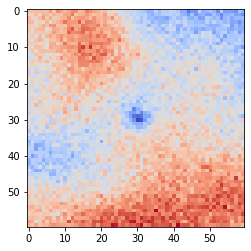

In [6]:
# Choose an object from the catalog
ra, dec = [ras[16],decs[16]]
width = 30/60.

# Build the box around the object and cut out a submap from the larger map
box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])

if imap_d56 is not None:
    stamp = imap_d56.submap(box)
else:
    stamp = imap.submap(box)

# Visualize the submap
plt.imshow(stamp, cmap = cm.coolwarm)

## Stacking point sources and using reproject

If we want to stack objects in the map it's relatively easy to do so, but we need to use a slightly different approach.  Instead of using a bounding box and cutting a submap from the map we can use pixell's `reproject.thumbnails` function to cut out "stamps" that are reprojected at the center of each object. 

Reprojecting means that we avoid stacking point sources that are distorted due to the rectangular projection of the overall map, as the reprojection will automatically center the "stamp" basis on each individual point source. Users can specify the type of projection using the "proj" keyword. The default is a "gnomonic" projection which projects to a plane that's tangential to the center source so that any distortions are radially symmetric.

Text(0.5, 0, 'Degrees')

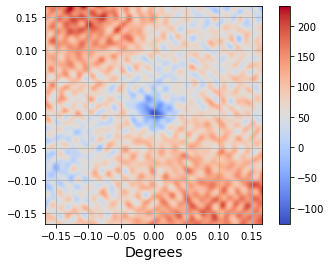

In [7]:
#Reproject the above source and plot - again we need to check if we're using the d56 or the full map 

# Set the size of the stamp:
r_arcmin = 10.  #Define the radius of the image in arcminutes
r = r_arcmin*np.pi/(60 * 180)  # convert arcminutes to radians 

if imap_d56 is not None:
    stamp = reproject.thumbnails(imap_d56, coords = np.deg2rad([decs[16], ras[16]]), res =  0.0000454440, r = r)
else:
    stamp = reproject.thumbnails(imap, coords = np.deg2rad([decs[16], ras[16]]), res =  0.0000454440, r = r)


extent = [-r_arcmin/60., r_arcmin/60., -r_arcmin/60., r_arcmin/60.]
plt.imshow(stamp, extent=extent,cmap = cm.coolwarm)
plt.colorbar()
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)

We see the utility of `reproject.thumbnails` in action: the source is now centered in the new coordinates! Now we stack all of the reprojected sources:

Text(0.5, 0, 'Degrees')

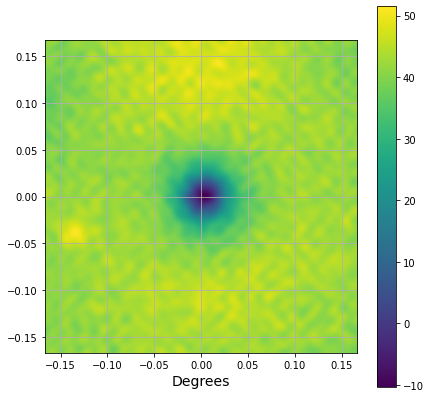

In [8]:
N = len(ras)
stack = 0
c = 0 # counter to check how many thumbnails we are stacking

if imap_d56 is not None:
    for i in range(N):
        stamp_new = reproject.thumbnails(imap_d56, coords = np.deg2rad([decs[i], ras[i]]), res = 0.0000454440, r=r)
        if stamp_new is None: continue
        stack += stamp_new
        c+=1

else:
    for i in range(N):
        stamp_new = reproject.thumbnails(imap, coords = np.deg2rad([decs[i], ras[i]]), res = 0.0000454440, r=r)
        if stamp_new is None: continue
        stack += stamp_new
        c += 1
    
stack /= c

# Plot the Stack
plt.figure(figsize = (7,7))
plt.imshow(stack, extent = extent)
plt.grid(True)
plt.colorbar()
plt.xlabel("Degrees", fontsize = 14)

It looks like the average source in our catalog is a well-defined cold spot relative to the surrounding CMB. This is qualitatively consistent with our understanding of a typical thermal-SZ cluster observed at 150 GHz (see e.g. [Carlstrom et al 2002](https://doi.org/10.1146/annurev.astro.40.060401.093803)). We examine tSZ clusters in  more detail in [Section 6](Section_6_Component_separated_maps.ipynb).

## Applications: Aperture Photometry and Radial Binning
Stamps are especially useful for additional analysis techniques that rely on the source being centered in the frame. One such technique is Aperture Photometry (AP), which can be used to calculate the brightness of objects. 

This code calculates the average temperature of an aperture: a circle of radius $x$ centered at the origin. It then finds the temperature of a ring of equal area around the circle (outer radius $\sqrt{2}x$), and subtracts the temperature of this ring from the temperature of the aperture.  We repeat this for multiple radii and can then plot the AP result against radii.

This code gives a good introduction to Aperture Photometry, however, there are a few drawbacks.  For example we don't account for distortions in the area of each pixel due to projection effects.  In order to better deal with these effects, and if you're interested in running more complex routines on these stamps we encourage you to consult the package developed by Emmanuel Schaan called [Thumbstack](https://github.com/EmmanuelSchaan/ThumbStack).

In [9]:
def aper_photo(x, radii_map, plot):
    '''calculates the flux-background for a single aperature'''
    zeros = np.zeros(np.shape(radii_map))
    
    circle_sum = np.sum(np.where(radii_map < x, plot, zeros))
    circle_num = np.sum(np.where(radii_map < x, 1, zeros))
    
    ring_sum = np.sum(np.where(radii_map < np.sqrt(2)*x, plot, zeros)) - circle_sum
    ring_num = np.sum(np.where(radii_map < np.sqrt(2)*x, 1, zeros)) - circle_num
    return np.nan_to_num(circle_sum/circle_num - ring_sum/ring_num)

def aper_plot(r, radii, stamp):
    '''Creates the aperature photometry plot for a given stamp'''
    aper_plot = np.zeros(np.shape(r))
    for i in range(np.size(r)):
        aper_plot[i] = aper_photo(r[i], radii, stamp)
    return aper_plot

<ipython-input-9-c511c47aa7f0>:10: RuntimeWarning: invalid value encountered in double_scalars
  return np.nan_to_num(circle_sum/circle_num - ring_sum/ring_num)


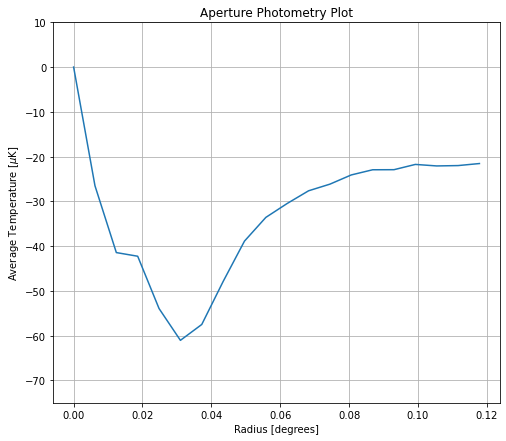

In [10]:
# Call the function modrmap that stores the radii in degrees of each pixel from the center
radii = enmap.modrmap(stamp.shape, stamp.wcs)*180/np.pi

# Determine the bounds for the bins
r_max = np.max(radii)
r_min = np.min(radii)

# define the radii we want for the aperature plot, note the maximum aperature radius is chosen to avoid edge effects
r = np.linspace(r_min, r_max/2, 20)


plt.figure(figsize = (8,7))
plt.title("Aperture Photometry Plot")
plt.xlabel("Radius [degrees]")
plt.ylabel("Average Temperature [$ \mu $K]")
plt.ylim(-75, 10)
plt.grid(True)
plt.plot(r, aper_plot(r, radii, stamp))
plt.show()

The idea with aperture photometry is that the circle is a guess for the size of the object itself and the ring is the "background". In the plot above, the curve is about zero initially, this is because the outer ring falls entirely within the object, so the background and the circle are close to the same temperature. For greater radii the curve tilts away from zero as the temperature in the two increasingly differ and the ring "ascends" out of the source. Finally, we see the curve flatten off; this indicates that we've fully enclosed the pointsource.

The stamp corresponding to this APp profile is shown below:

Text(0.5, 0, 'Degrees')

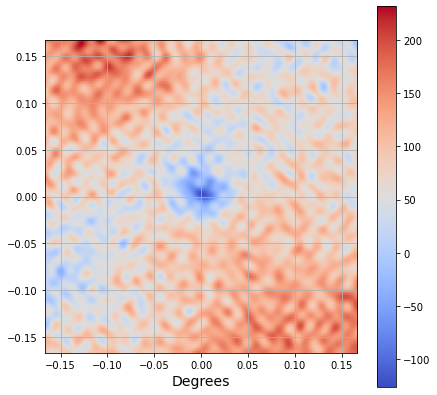

In [11]:
plt.figure(figsize = (7,7))
plt.imshow(stamp, extent=extent,cmap = cm.coolwarm)
plt.colorbar()
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)

## Radial Binning
We will also take a moment to demonstrate how to radially bin a point source to look at the profile. 

Below is code that bins data radially, fits the binned data with an exponential curve, and then creates a 2D profile from the fit to approximate the 2D profile of the point source. This code can of course be adapted for other uses but here we will look at the stack of point sources, since single sources tend to be less radially symmetric. 

In [12]:
def bin_stamp(data2d, modrmap, bin_edges):
    '''gives the centers and averages for radial bins of a 2d plot'''
    #get centers of each bin
    centers = (bin_edges[1:]+bin_edges[:-1])/2.
    
    #sort indices by corresponding radial bin
    digitized = np.digitize(modrmap.reshape(-1), bin_edges,right=True)

    #get average of each radial bin
    count = np.bincount(digitized)[1:-1]
    res = np.bincount(digitized,(data2d).reshape(-1))[1:-1]/count
    return centers,res

In [13]:
# Define the fit function
def func(x, A, B, C):
    return A*np.exp(B*x) + C

# Set the number of bins
N_bins = 50

# r_edge is the radius of the largest circle that can fit entirely within the box
r_edge = r_max/np.sqrt(2)

step = (r_edge - r_min)/N_bins

# Create the bin edges
bin_edges = np.arange(r_min, r_edge, step)

# Use the binner function to get the average temp for each radius
cents, res = bin_stamp(stack, radii, bin_edges)

In [14]:
# Fit the results from the binner with the exponential
popt, pcov = curve_fit(func, cents, res, p0 = [-1, -1, 80])
res_fit = func(cents, popt[0], popt[1], popt[2])

[Text(0, 0.5, 'Temperature [$ \\mu $K]'),
 Text(0.5, 0, 'Radius [degrees]'),
 Text(0.5, 1.0, 'Residuals')]

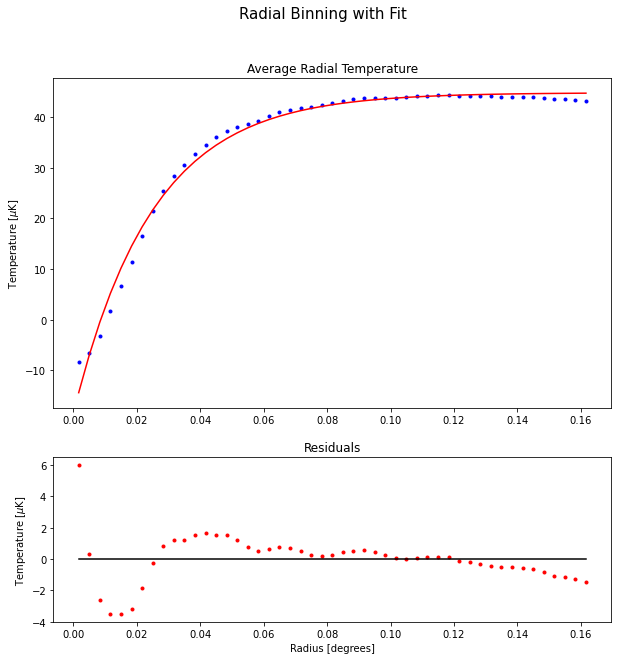

In [15]:
# Plot the radial temp curve and its fit
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10), gridspec_kw={'height_ratios': [2, 1]})
fig.figsize = (10, 9)
fig.suptitle('Radial Binning with Fit', fontsize = 15)

ax1.plot(cents, res, 'b.')
ax1.plot(cents, res_fit, 'r')
ax1.set(ylabel = r"Temperature [$ \mu $K]", title = "Average Radial Temperature")
ax2.plot(cents, res - res_fit, 'r.')

ax2.plot(cents, np.zeros(np.size(cents)), 'k')
ax2.set(xlabel = "Radius [degrees]",
        ylabel = r"Temperature [$ \mu $K]", title = "Residuals")

As shown in the plot above the radial binning curve is nearly exponential, with relatively small residuals. This code uses a fit instead of the raw binning data to "smooth" the values a bit, and so that data can be extrapolated past r-edge (where the corners of the stamp would create errors in the radial binning).  As is evident in the plots above the point sources can't be fit perfectly with this curve, feel free to try other fits by adjusting the function in the previous cells!

Radially binned 2d map


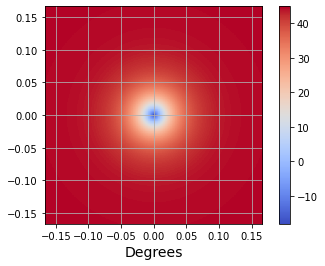

Stack with radial binning subtracted


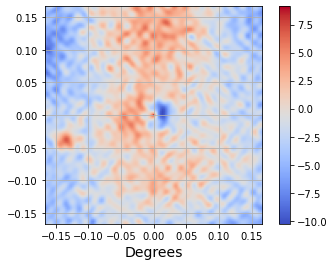

In [16]:
# Use the radial temp fit to get a 2d map
res_fit_2D = interp1d(cents,res_fit,kind='linear',fill_value='extrapolate')(radii)

# Plot the 2d fit map and the original stack with the fit subtracted
print("Radially binned 2d map")
plt.imshow(res_fit_2D,extent=extent,cmap = cm.coolwarm)
plt.colorbar()
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)
plt.show()

print("Stack with radial binning subtracted")
plt.imshow(stack - res_fit_2D,extent=extent,cmap = cm.coolwarm)
plt.colorbar()
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)
plt.show()

In the plot above we can see that the stack is slightly asymetric, this is most likely due to random variation which the stack is not large enough to average out, or due to the inadequacy of the exponential model.  It's also worth noting we've adjusted the scale above in order to make the residuals visible.

## Plot Messier objects

While users are free to search for objects in the maps using catalogs we've also provided a tool to plot random Messier objects from our maps below.  You can enter the Messier number of an object you'd like to look at or feel free to let the function generate an object at random.

In [17]:
def plot_messier(M = None):
    # M should be an integer 

    # read in a table of messier objects that overlap with our feild of view
    tbl = ascii.read(path + "messier_objs.csv", encoding = "utf-8-sig")

    # Check if user has given an object to look for
    if M != None:
        M = str('M') + str(M)
        A = list(tbl['M'])
        if M in A:
            obj = tbl[A.index(M)]
        else:
            print("Sorry that object isn't visible in this map")

    # If no object is given select a random one
    if M == None:
        obj = tbl[random.randrange(0, len(tbl))] 

    # Get the RA and DEC of the object
    ra = coord.Angle(obj["RA"], unit=u.hour) 
    dec = coord.Angle(obj["Declination"], unit = u.degree) 
    
    r = 20.*np.pi/(60 * 180)
    
    # Get a plot of the object
    if imap_d56 is not None:
        stamp = reproject.thumbnails(imap_d56 , coords = [dec.rad, ra.rad], r=r, res =  0.0000454440)
    else:
        stamp = reproject.thumbnails(imap , coords = [dec.rad, ra.rad],  r=r,res =  0.0000454440)
    
    if np.sum(stamp) == 0:
        print("This object wasn't in the D56 full resolution map so we'll switch to a downgraded view.")
        print("Note this may mean it's difficult to see this particular object, consider looking at it with the full depth map instead!")
        stamp = reproject.thumbnails(imap_dg , coords = [dec.rad, ra.rad],  r=r,res =  0.0000454440)
        

    # Establish name for the object, if the common name is given use that, if not 
    # we just use the NGC and M indentifiers
    if type(obj["Common Name"] ) == np.str_:
        name = str(obj["Common Name"])  + str(' NGC: ') + str(obj["NGC"]) + \
        str(' ') + str(obj["M"])
    else:
        name = str('NGC: ') + str(obj["NGC"])+ str(' ') + str(obj["M"])

    # Plot the object 
    plt.imshow((stamp))
    plt.title(name)
    plt.show()

    return 

This object wasn't in the D56 full resolution map so we'll switch to a downgraded view.
Note this may mean it's difficult to see this particular object, consider looking at it with the full depth map instead!


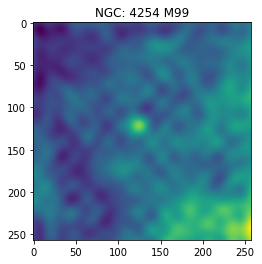

In [18]:
# Try this a few times - some of the objects may be clearer than others
plot_messier()

### Continue to the next section

[Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps.